In [0]:
# NOTES:
# 1. albumentations -> numpy
# 2. pil.open faster than cv2
# 3. 

# TODO
# 1. поддержка полутонового изображения
# 2. очень долго читаются картинки PIL + преобразования (мб их на GPU?)
# 3. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install colour-demosaicing

     |████████████████████████████████| 3.3MB 37.2MB/s 
     |████████████████████████████████| 1.6MB 56.4MB/s 


In [4]:
import numpy as np
import pandas as pd
import os

from pathlib import Path


import numpy as np
import torchvision
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

from albumentations import Compose, ToGray, Normalize, RandomCrop, Resize
#from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

print(os.listdir())

['.config', 'drive', 'sample_data']


In [0]:
def get_awgn_image(image, scale, loc=0.0):
    # scale = sigma
    noise3d = np.random.normal(loc=loc, scale=scale, size=image.shape)
    noisy_image = np.uint8(np.clip(image + noise3d, 0, 255))
    return noisy_image


def get_rgb_masks(shape):
    # GRBG
    g = np.zeros(shape)
    
    g[::2, ::2] = 1
    g[1::2, 1::2] = 1
    
    b = np.zeros(shape)
    b[1::2, ::2] = 1
    
    r = np.zeros(shape)
    r[::2, 1::2] = 1
    
    return r, g, b
    

def mosaic(image, rgb=True):
    h, w, _ = image.shape
    r_mask, g_mask, b_mask = get_rgb_masks((h,w))
    if rgb:
        blue, green, red = image[:, :, 2], image[:, :, 1], image[:, :, 0]
    else:
        blue, green, red = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return blue * b_mask + green * g_mask + red * r_mask


def mosaic_awgn_demosaic(image, sigma, rgb=True):
    mosaic_im = mosaic(image, rgb=rgb)
    noisy_mosaic_im = get_awgn_image(mosaic_im, sigma)
    demosaic_noisy_im = demosaicing_CFA_Bayer_Menon2007(noisy_mosaic_im, 'GRBG')
    if rgb:
        return demosaic_noisy_im
    # rgb to bgr
    return demosaic_noisy_im[:, :, [2, 1, 0]]


class ImageDataset(Dataset):

    def __init__(self, image_paths, augmentations=None, max_sigma=25):
        super().__init__()
        self.image_paths = image_paths
        self.size = len(image_paths)
        self.max_sigma = max_sigma
        self.augmentations = augmentations

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        #image_idx = np.random.randint(0, self.size)
        image = self.load_image(self.image_paths[idx])
        #print(idx)
        
        mode = self.get_random_mode()
        sigma = self.get_random_sigma()
        
        if mode == 'awgn':
            noisy_im = get_awgn_image(image, sigma)
        else:
            noisy_im = mosaic_awgn_demosaic(image, sigma)
            
        noisy_im = np.array(noisy_im / 255., dtype='float32')
        
        label = 0 if mode == 'bayer' else 1
        
        return transform(self.augmentations(image=noisy_im)['image']), label, sigma

    def load_image(self, image_path):
        #print('Opening image... ', image_path )
        image = Image.open(image_path)
        image.load()
        # TODO дублирование по каналам, если изображение полутоновое
        return np.array(image)
    
    def get_random_mode(self):
        return np.random.choice(['awgn', 'bayer'])
    
    def get_random_sigma(self):
        return np.random.randint(0, self.max_sigma)

## Аугментация и деление на обучение и валидацию

In [6]:
class_names = ['bayer', 'awgn']

train_transforms = Compose([
    Resize(224,224),
    #RandomCrop(224,224),
    ToGray(p=1.0),
])

val_transforms = Compose([
    Resize(224,224),
    ToGray(p=1.0),
])

IMAGES_DIR = Path('drive/My Drive/dl_noise_classification/raw_images/')
im_paths = list(IMAGES_DIR.rglob('*.jpg'))
#print(im_paths[:10])
n_images = len(im_paths)
n_train = int(n_images * 0.8)

train_paths = im_paths[:100]
val_paths = im_paths[100:120]
print("Train size: {}\nValid size: {}".format(len(train_paths), len(val_paths)))

Train size: 100
Valid size: 20


In [0]:
from tqdm import tqdm

In [0]:
for path in tqdm(im_paths):
    im = Image.open(path)
    im.load()
    im = np.array(im)
    if len(im.shape) != 3:
        print(path)

  0%|          | 23/5020 [00:02<12:30,  6.66it/s]

drive/My Drive/dl_noise_classification/raw_images/000000024021.jpg


 17%|█▋        | 854/5020 [08:31<50:09,  1.38it/s]

drive/My Drive/dl_noise_classification/raw_images/000000061418.jpg


 24%|██▍       | 1202/5020 [11:56<43:53,  1.45it/s]

drive/My Drive/dl_noise_classification/raw_images/000000274219.jpg


 38%|███▊      | 1891/5020 [19:01<33:24,  1.56it/s]

KeyboardInterrupt: ignored

In [0]:
train_dataset = ImageDataset(train_paths, train_transforms)
val_dataset = ImageDataset(val_paths, val_transforms)

batch_size = 20
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Пример одного батча из обучающих данных

In [0]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.numpy().transpose((1, 2, 0))
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    #plt.pause(0.001)

X_batch, y_batch, s_batch = next(iter(train_dataloader))

for x_item, y_item, sigma in zip(X_batch, y_batch, s_batch):
    show_input(x_item, title="{} | sigma = {}".format(class_names[y_item], sigma))

336
3598


KeyboardInterrupt: ignored

## 25 Случайных картинок из Train Dataset

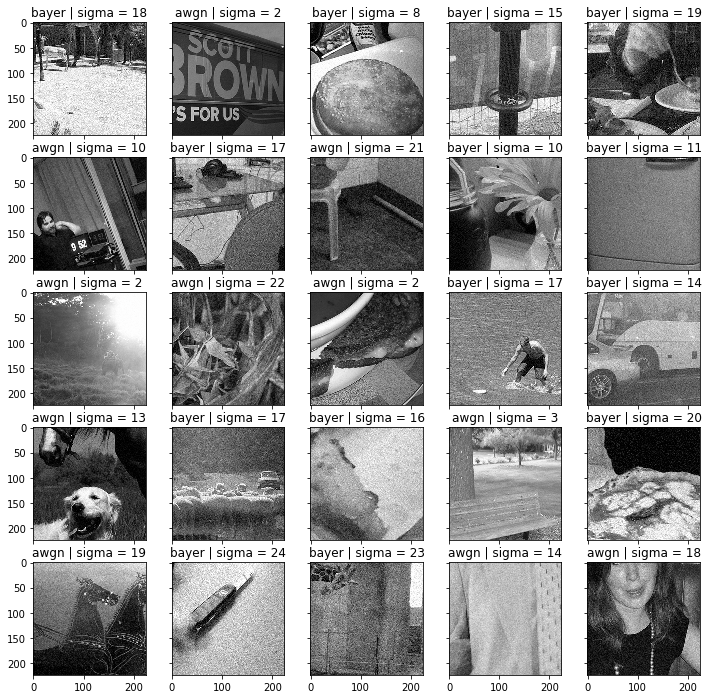

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_plate = int(np.random.uniform(0, len(train_paths)))
    im_val, label, sigma = train_dataset[random_plate]
    imshow(im_val.data.cpu(), title="{} | sigma = {}".format(class_names[label], sigma), plt_ax=fig_x)

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    val_loss = []
    train_loss = []
    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # training mode
            else:
                dataloader = val_dataloader
                model.eval()   # evaluate mode (dropout + bn)

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, _ in dataloader:
                #print(inputs, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.cpu().item()
                running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            history = train_loss if phase == 'train' else val_loss
            history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss, val_loss

## Обучение сети ResNet152 с последним линейным слоем

In [0]:
model = models.resnet152(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.1)

In [0]:
loss_train_history, loss_val_history = train_model(model, loss, optimizer, scheduler, num_epochs=100)

Epoch 0/99:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6481 Acc: 0.6400
val Loss: 0.7847 Acc: 0.5000
Epoch 1/99:
train Loss: 0.6964 Acc: 0.5200
val Loss: 0.7563 Acc: 0.4500
Epoch 2/99:
train Loss: 0.6876 Acc: 0.6300
val Loss: 0.6574 Acc: 0.6500
Epoch 3/99:
train Loss: 0.6852 Acc: 0.5600
val Loss: 0.9316 Acc: 0.6000
Epoch 4/99:
train Loss: 0.6689 Acc: 0.5500
val Loss: 0.6309 Acc: 0.6000
Epoch 5/99:
train Loss: 0.6337 Acc: 0.6800
val Loss: 0.8083 Acc: 0.6000
Epoch 6/99:
train Loss: 0.6494 Acc: 0.6100
val Loss: 0.6195 Acc: 0.6000
Epoch 7/99:
train Loss: 0.7034 Acc: 0.5400
val Loss: 0.6473 Acc: 0.6000
Epoch 8/99:
train Loss: 0.6881 Acc: 0.6000
val Loss: 0.6373 Acc: 0.5500
Epoch 9/99:
train Loss: 0.6474 Acc: 0.6300
val Loss: 0.6357 Acc: 0.6000
Epoch 10/99:
train Loss: 0.6777 Acc: 0.5800
val Loss: 0.7236 Acc: 0.5500
Epoch 11/99:
train Loss: 0.6567 Acc: 0.5500
val Loss: 0.6856 Acc: 0.4500
Epoch 12/99:
train Loss: 0.6209 Acc: 0.6800
val Loss: 0.6267 Acc: 0.7000
Epoch 13/99:
train Loss: 0.6297 Acc: 0.6100
val Loss: 0.6548 Acc: 0.5500


## PLOT Train and Val loss

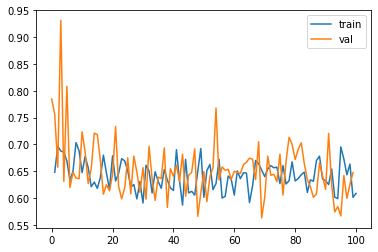

In [0]:
plt.plot(range(1, 100 + 1), loss_train_history, loss_val_history)
plt.legend(["train", "val"])
plt.show()

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/dl_noise_classification/model.pth')

In [0]:
plt.savefig('drive/My Drive/dl_noise_classification/train_val_loss.jpg')

<Figure size 432x288 with 0 Axes>

## Тестовая выборка и data loader

In [0]:
test_paths = im_paths[120:150]
test_dataset = ImageDataset(test_paths, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=20, shuffle=True, num_workers=0)

## Загрузка обученной модели

In [15]:
params_dict = torch.load('drive/My Drive/dl_noise_classification/model.pth')
model = models.resnet152(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(params_dict)
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [55]:
test_predictions = []
test_img_sigmas = []
test_true = []
for inputs, labels, sigmas in tqdm(test_dataloader):
    test_true.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_sigmas.extend(sigmas)
    
y_pred = np.concatenate(test_predictions)
y_true = np.concatenate(test_true)


100%|██████████| 2/2 [00:03<00:00,  2.28s/it]


In [56]:
print(y_pred)

[ 0.47227594  0.9996625   0.5525067   0.5744043   0.5718775   0.60436624
  0.23836468  0.659989    0.5298564   0.13553543  0.36954176  0.5124735
  0.52312505  0.52708185  0.5880793   0.45013088  0.56109136  0.57235265
  0.5711936   0.12979674  0.5353847   0.6422717   0.5695753   0.59789217
  0.31670642  0.54615486  0.47783807  0.03903731  0.5645977   0.5616492 ]


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## ROC Curve

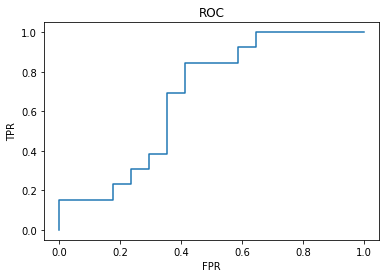

In [57]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)

In [58]:
thresholds

array([ 1.9996625 ,  0.9996625 ,  0.659989  ,  0.59789217,  0.5880793 ,
        0.5744043 ,  0.57235265,  0.5718775 ,  0.5711936 ,  0.5695753 ,
        0.5525067 ,  0.54615486,  0.5298564 ,  0.5124735 ,  0.47783807,
        0.47227594,  0.45013088,  0.03903731], dtype=float32)

In [59]:
y_true

array([0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1])

In [61]:
print("AUC: {}".format(roc_auc_score(y_true, y_pred)))


AUC: 0.6787330316742082


## Точность в зависимости от порога

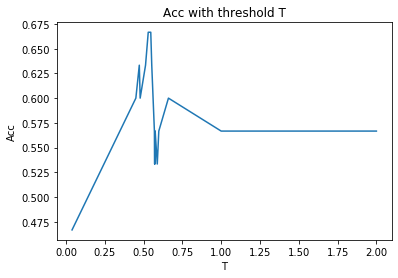

In [70]:
acc_history = []
t_history = []
for thresh in thresholds:
    y_hat = np.copy(y_pred)
    y_hat[y_hat > thresh] = 1
    y_hat[y_hat <= thresh] = 0
    accuracy = accuracy_score(y_true, y_hat)

    t_history.append(thresh)
    acc_history.append(accuracy)
    #print("Accuracy: {}, with threshold: {}".format(accuracy, thresh))

plt.title('Acc with threshold T')
plt.xlabel('T')
plt.ylabel('Acc')
plt.plot(t_history, acc_history)
